<a href="https://colab.research.google.com/github/majidsh97/project-2/blob/main/AST_GAN_ebi_hayede(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/inzva/Audio-Style-Transfer.git
!pip install -q tensorflow-io
!pip install librosa==0.8
!pip install tensorflow-gan
!pip install -q -U tensorflow-addons
#sss

Cloning into 'Audio-Style-Transfer'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.
     |████████████████████████████████| 22.3MB 1.3MB/s 
     |████████████████████████████████| 184kB 4.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=a336dc645cbc0a1bbbe63ef6c53e764383afa49cf1110cab774e5eb82c74658c
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3
     |████████████████████████████████| 368kB 5.5MB/s 
     |████████████████████████████████| 1.1MB 5.3MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import IPython
import matplotlib.pyplot as plt
import os
import tensorflow_io as tfio
from tensorflow.keras import layers
import librosa
import time
import tensorflow_gan as tfgan
from scipy.signal import resample
import tensorflow_addons as tfa

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:

#newvalue = a * value + b. a = (max'-min')/(max-min) and b = max - a * max

def tensor_to_audio(tensor,fs,N_FFT):
  a = np.zeros_like(tensor)
  a = np.exp(tf.transpose(tensor).numpy()) - 1
  
  # This code is supposed to do phase reconstruction
  p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
  for i in range(10):
      S = a * np.exp(1j*p)
      x = librosa.istft(S)
      p = np.angle(librosa.stft(x, N_FFT))
  return x
  OUTPUT_FILENAME =   '1.wav'
  librosa.write_wav(OUTPUT_FILENAME, x, fs)

def gram(inputs):
  #batch nist age batch mikhay bayad ye b be harf ha va ye 1 be inputs.shape azafe beshe
  gram=0
  gram = tf.matmul(tf.transpose(inputs),inputs)/(inputs.shape[0]*inputs.shape[1])
    
  """  if len(inputs.shape)==4:
    ij=tf.cast(inputs.shape[1]*inputs.shape[2],'float32')
    gram=tf.linalg.einsum('bijk,bijd->bkd',inputs,inputs)/ij
  else:
   if len(inputs.shape)==3:
    i=tf.cast(inputs.shape[1],'float32')
    gram=tf.linalg.einsum('bjk,bjd->bkd',inputs,inputs)/i"""

  return gram

def abs_angle_to_complex(abs,ang):
  ang=tf.complex(0.0,ang)
  ang=tf.math.exp(ang)
  z=tf.complex(abs,0.0)*ang
  return z

def t2a(tensor, frame_length, frame_step, fft_length):
  a=tf.complex(tensor,0.0)
  a=tf.cast(a,tf.complex64)
  a = tf.math.exp(a) - 1
  p = 2 * np.pi* tf.random.uniform(a.shape,dtype=tf.float32) - np.pi
  p=tf.complex(0.0,p)
  for i in range(10):
    S = a * tf.math.exp(p)
    x=tf.signal.inverse_stft(S, frame_length, frame_step, fft_length)
    stft=tf.signal.stft(x,frame_length, frame_step,fft_length)
    p = tf.math.angle(stft)
    p = tf.complex(0.0,p)
  return x

def imshow(img):
  plt.imshow(img+127.5/255.0)

def linear_scale(x,max_to=1,min_to=0):
  max=x.max()
  min=x.min()
  a = (max_to-min_to)/(max-min)
  b = max - a * max
  newvalue = a * x + b  
  return newvalue


def display(x,fs):
  IPython.display.display(IPython.display.Audio(x,rate=fs))

def invspectogram(spect,angle,frame_length,frame_step,fft_length):
  spect = abs_angle_to_complex(tf.math.expm1(spect),angle)
  y_invstft=tf.signal.inverse_stft(spect,frame_length,frame_step,fft_length)
  return y_invstft

def spectrogram(x,frame_length , frame_step,fft_length ):
  y=tf.signal.stft(x,frame_length,frame_step,fft_length)
  content_angle=tf.math.angle(y)
  content_spect=tf.math.log1p(tf.abs(y))
  return [content_spect , content_angle]

def window_stack(a, stepsize, width):
    return tf.stack( [a[i:1+i-width or None:stepsize]  for i in range(0,width) ],-1)

class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
"""a=tfio.audio.AudioIOTensor(FILE)
fs=a.rate.numpy()
a=a.to_tensor()[:,0]
a=tf.cast(a,tf.float32).numpy()
a = a / 32768.0"""

In [ ]:

def get_sliced_spectrom(s,p):
  #x=tf.roll(x,tf.random.uniform((),0,int(n/2),dtype=tf.int32),0)
  #x = window_stack(x,int(fs_content),fs_content)[...,None]

  t = int(s.shape[0]/s.shape[1])*s.shape[1]
  s_slice = np.reshape(s[:t,:],(-1,s.shape[1],s.shape[1]))
  p_slice = np.reshape(p[:t,:],(-1,s.shape[1],s.shape[1]))
  l2=tf.reduce_sum(tf.square(s_slice),[1,2])
  condition=l2>1e4
  s_slice = s_slice[condition,...,None]
  p_slice = p_slice[condition,...,None]

  return tf.concat( [s_slice,p_slice ] ,-1)



In [ ]:
frame_length=1024
frame_step=256
fft_length = None
"""
singer = 'ebi'
DIR='/content/drive/My Drive/music/'+singer+'/'
musiclist=os.listdir(DIR)
data_list=[]
for l in musiclist:
  print(l)
  
  FILE=DIR+l+'/vocals.wav'
  a,fs=librosa.load(FILE)

  s,p = spectrogram(a,frame_length,frame_step,fft_length)
  s=s[:,:s.shape[1]-1]
  p=p[:,:p.shape[1]-1]
  data_list.append(get_sliced_spectrom(s,p))


"""

"\nsinger = 'ebi'\nDIR='/content/drive/My Drive/music/'+singer+'/'\nmusiclist=os.listdir(DIR)\ndata_list=[]\nfor l in musiclist:\n  print(l)\n  \n  FILE=DIR+l+'/vocals.wav'\n  a,fs=librosa.load(FILE)\n\n  s,p = spectrogram(a,frame_length,frame_step,fft_length)\n  s=s[:,:s.shape[1]-1]\n  p=p[:,:p.shape[1]-1]\n  data_list.append(get_sliced_spectrom(s,p))\n\n\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""BATCH_SIZE=1
BUFFER_SIZE=1000
train_dataset = tf.concat(data_list,0)
np.save(singer,train_dataset.numpy())
#np.load(singer+'.npy')"""

In [ ]:
#hayede[:ebi.shape[0]].shape


In [ ]:
"""#p=(x[1]/np.pi + 1)/2
p = x[1]/np.pi

#p = np.abs(p)
p = np.cumsum(p,0)
p = np.cumsum(p,1)

plt.imshow(p)#p[1:,:]-p[:-1,:])
plt.show()
p[:,1:] -= p[:,:-1].copy()
p[1:,:] -= p[:-1,:].copy()

plt.imshow(p)
#p = (p*2-1)*np.pi
p= p*np.pi
y=invspectogram(x[0],p,frame_length,frame_step,fft_length)
display(y,fs_content)"""

In [ ]:
"""k=(1,2)
y1=layers.AveragePooling2D((1,2))(x[0][None,:,:,None])[0,:,:,0]
y2=layers.AveragePooling2D((2,1))(x[0][None,:,:,None])[0,:,:,0]

print(y1.shape , y2.shape)
y=(y1[:y2.shape[0],:]+y2[:,y1.shape[1]])/2

y1=y1[:y.shape[0],:y.shape[1]]+y
print(y1.shape)"""

In [ ]:
"""

p = x[1]/np.pi

#p = np.abs(p)
p = np.cumsum(p,0)
p = np.cumsum(p,1)

plt.imshow(p)#p[1:,:]-p[:-1,:])
plt.show()


k=(1,2)
D=layers.AveragePooling2D(k)
y1=D(x[0][None,:,:,None])
y1=D(y1)
y1=D(y1)
y1=D(y1)
y1=D(y1)
y1=D(y1)
y1=D(y1)
y1=D(y1)
#y1=D(y1)

print(y1.shape)
plt.imshow(y1[0,:,:,0])
plt.show()

U=layers.UpSampling2D(k,interpolation='bilinear')
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
y1 = U(y1)
#y1 = U(y1)

y1=y1[0,:,:,0]
plt.imshow(y1)
plt.show()

p=y1.numpy()
#p[:,1:] -= p[:,:-1].copy()
#p[1:,:] -= p[:-1,:].copy()

#p = (p*2-1)*np.pi
p= p*np.pi
z=y1
plt.imshow(p)
plt.show()


y=invspectogram(y1,x[1],frame_length,frame_step,fft_length)
#p=spectrogram(y,frame_length,frame_step,fft_length)
display(y,fs_content)"""

In [ ]:
"""o=(t+z)/2
#o=o[0,:,:,0]
o=o.numpy()
plt.imshow(o)
o[:,1:] -= o[:,:-1].copy()
o[1:,:] -= o[:-1,:].copy()

#p = (p*2-1)*np.pi
o= o*np.pi
y=invspectogram(x[0],o,frame_length,frame_step,fft_length)
display(y,fs_content)"""

In [ ]:
hayede_np = np.load('/content/drive/My Drive/music/hayede.npy','r')
ebi_np = np.load('/content/drive/My Drive/music/ebi.npy','r')

#hayede[:,:,:,0] = hayede[:,:,:,0] / 2.5 - 1
#ebi[:,:,:,0] = ebi[:,:,:,0] / 2.5 - 1

#hayede[:,:,:,1] = hayede[:,:,:,1] / np.pi 
#ebi[:,:,:,1] = ebi[:,:,:,1] / np.pi 

BATCH_SIZE=32
hayede = tf.data.Dataset.from_tensor_slices(hayede_np).shuffle(250).batch(BATCH_SIZE,True).prefetch(2)
ebi = tf.data.Dataset.from_tensor_slices(ebi_np).shuffle(250).batch(BATCH_SIZE,True).prefetch(2)


In [ ]:


cross=tf.keras.losses.BinaryCrossentropy(True)

def disc_loss(real_disc,fake_disc):
  real_loss=cross(tf.ones_like(real_disc),real_disc)
  fake_loss=cross(tf.zeros_like(fake_disc),fake_disc)
  return  real_loss + fake_loss
  #return tfgan.losses.losses_impl.wasserstein_discriminator_loss(real_disc,fake_disc)


def gen_loss(fake_disc):
  return cross(tf.ones_like(fake_disc),fake_disc)
  #return tfgan.losses.losses_impl.wasserstein_generator_loss(fake_disc)

  

genBlock


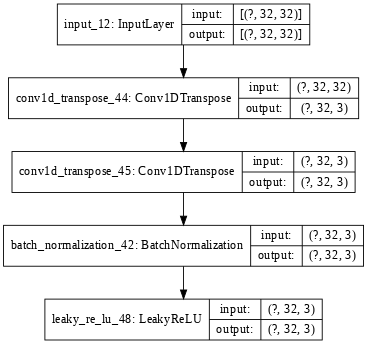

------------------------------
discBlock


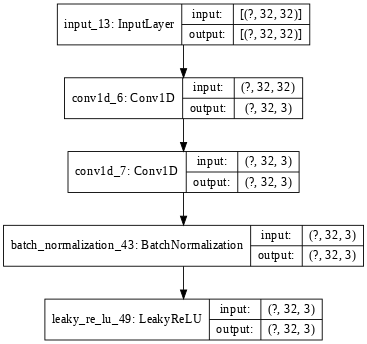

------------------------------


In [ ]:
stride=1
dilation=1
kernel_size = 3
init = tf.keras.initializers.RandomNormal(stddev=0.02)
const = None #tf.keras.constraints.MaxNorm() #ClipConstraint(0.01)
up_down=(2,2)

class WeightedSum(tf.keras.layers.Layer):
  def __init__(self,name):
    super(WeightedSum,self).__init__()
    self.alpha = tf.Variable( tf.abs(init((1,))), trainable=True ,  dtype=tf.float32 , name=name )

  def call(self,inp):
    #return (1-self.alpha) * inp[0] + self.alpha * inp[1]
    return (1-self.alpha) *inp[0] +  self.alpha * inp[1] #+ tf.random.normal(inp[1].shape[1:],0.02)

class AddNoise(tf.keras.layers.Layer):
  def __init__(self,name):
    super(AddNoise,self).__init__()

  def call(self,inp):
    return inp + tf.random.rand
class discBlock(layers.Layer):
  def __init__(self,f):
    super(discBlock,self).__init__()
    #-------------------------------
    self.c1 = layers.Conv1D(f,kernel_size,stride,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )
    self.c2 = layers.Conv1D(f,kernel_size,1,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )
    self.bn = layers.BatchNormalization()
    #self.innorm = tfa.layers.normalizations.InstanceNormalization()

    self.lr = layers.LeakyReLU(0.2)
    #self.drop1=layers.Dropout(0.1)
    #-------------------------------
    #self.avg = layers.AveragePooling2D(up_down)
    #-------------------------------

    
  def call(self,inp):
    x = inp
    x = self.c1(inp)
    x = self.c2(x)
    x = self.bn(x)
    #x = self.innorm(x)
    x = self.lr(x)
    #x = self.drop1(x)
    #x = self.avg(x)
    return x
  
  def plot(self):
    _inp = layers.Input((32,32))
    o=self.call(_inp)
    m=tf.keras.Model(_inp,o)
    img = tf.keras.utils.plot_model(m,'discBlock.png',True,dpi=64)
    print("discBlock")
    IPython.display.display(img)
    print('------------------------------')


class genBlock(layers.Layer):
  def __init__(self,f,use_last_layer):
    super(genBlock,self).__init__()
    #-------------------------------
    #self.up1 = layers.UpSampling2D(up_down)
  #-----------------------------------------
    self.c1 = layers.Conv1DTranspose(f,kernel_size,stride,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )
    self.c2 = layers.Conv1DTranspose(f,kernel_size,1,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )
    self.bn = layers.BatchNormalization()
    #self.innorm = tfa.layers.normalizations.InstanceNormalization()
    self.lr = layers.LeakyReLU(0.2)


    #-------------------------------
    
  def call(self,inp):
    x = inp
    #x = self.up1(x)
    x = self.c1(x)
    x = self.c2(x)
    x = self.bn(x)
    #x = self.innorm(x)
    x = self.lr(x)


    return x
    
  def plot(self):
    _inp = layers.Input((32,32))
    o=self.call(_inp)
    m=tf.keras.Model(_inp,o)
    img = tf.keras.utils.plot_model(m,'genBlock.png',True,dpi=64)
    print("genBlock")
    IPython.display.display(img)
    print('------------------------------')
  
    

def udown(inp,f):
  x = inp
  f=int(f/2)

  #x = layers.Conv2D(f,5,stride,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )(x)
  #------------------------ bala bayad add she -----------------------------------
  x = discBlock(f)(x)

  return x

def uup(inp,f,use_last_layer):
  x=inp
  f = f * 2
  x = genBlock(f,use_last_layer)(x)
  #------------------------ paiin bayad add she -----------------------------------
  #x = layers.Conv2DTranspose(f,5,stride,dilation_rate=dilation,padding='SAME',use_bias=False, kernel_initializer=init , kernel_constraint=const )(x)

  return x

def get_discriminator(inp,num,f):
  x=inp
  layer_list=[]
  for i in range(num):
    x=udown(x,f)
    f=x.shape[-1]
    layer_list.append(x)

  return layer_list #tf.keras.models.Model(inp,x)

def get_generator(inp,num,f,latent_dim,is_latent=True):
  x = inp
  use_last_layer = False
  """
    if is_latent == True:
    inp = layers.Input((latent_dim,),dtype=tf.float32)
    x = layers.Dense(input_shape[0]*input_shape[1]*input_shape[2],kernel_constraint=const)(x)
    x = layers.Reshape(input_shape)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
  """
  layer_list=[]
  for i in range(num):
    if i == num-1:
      use_last_layer=True
    x=uup(x,f,use_last_layer)
    f=x.shape[-1]



  return x #tf.keras.models.Model(inp,x)


gb=genBlock(3,True)
gb.plot()
db=discBlock(3)
db.plot()

In [ ]:
def get_alphas(_model):
  alphas=[]
  for v in _model.non_trainable_variables:
    if v.name[:5]=='alpha':
      alphas.append(v)
  return alphas

def set_alphas(alphas,new_values):
  for a,nv in zip(alphas,new_values):
    a.assign(nv)

#alphas= get_alphas(unet)
#print(alphas)
#new_values = tf.ones_like(alphas) * 0.2
#set_alphas(alphas , new_values)
#print(alphas)


In [ ]:
"""def get_filters(f_size):
  filters = [f_size*2**i for i in range(0,6)]
  return filters
"""
#discriminator.trainable = True


Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpx (InputLayer)            [(None, 256)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
reshape_5 (Reshape)          (None, 512, 1)            0         
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 512, 1)            0         
_________________________________________________________________
gen_block_31 (genBlock)      (None, 512, 128)          50048     
_________________________________________________________________
gen_block_32 (genBlock)      (None, 512, 64)           37120     
_________________________________________________________________
gen_block_33 (genBlock)      (None, 512, 32)         

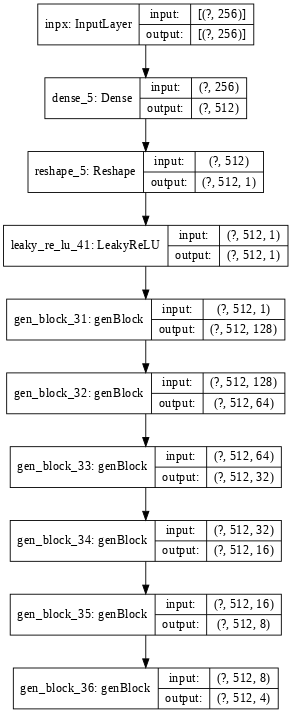

In [ ]:
def get_unet(inpx,num,f_total,w):
    
  x=inpx
  f=f_total

  x = layers.Dense((512*1))(x)
  x = layers.Reshape((512,1))(x)
  x = layers.LeakyReLU()(x)
  
  use_last_layer = False
  for i in range(num):
    if i == num-1:
      use_last_layer=True

    x=uup(x,f,use_last_layer)
    f=x.shape[-1]  

  #x = layers.Conv2DTranspose(1,kernel_size,padding='SAME',use_bias=True, kernel_initializer=init , kernel_constraint=const )(x)
 
  return tf.keras.Model(inpx , x)


input_shape = (512,512,1)
inpx = layers.Input((256,) , name = 'inpx')
#inpy = layers.Input(input_shape , name='inpy')
NUM = 6
FILTER_SIZE=8
unet= get_unet(inpx,NUM,2**FILTER_SIZE,8)
unet.summary()
tf.keras.utils.plot_model(unet,dpi=64,show_shapes=True)


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
disc_inp = layers.Input(input_shape)

#disc_inp = layers.GaussianNoise(0.05)(disc_inp)
layers_x = get_discriminator(disc_inp,NUM,FILTER_SIZE)
style_outputs=layers_x
#style_outputs = [gram_matrix(style_output)
#                     for style_output in layers_x]
x = layers.Flatten()(layers_x[-1])
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1,kernel_constraint=const)(x)
layers_x.append(x)
style_outputs.append(x)
discriminator = tf.keras.Model(disc_inp ,  style_outputs)

discriminator.summary()
tf.keras.utils.plot_model(discriminator,dpi=64,show_shapes=True)


In [ ]:
def get_noise():
  return tf.random.normal((BATCH_SIZE , 256))

LR = 0.1
generator = unet
NUM_SAMPLE=5
#x_const=next(iter(ebi))[0]
x_spect_const= get_noise()[:16,...]#x_const[...,0]
#x_angle_const= x_const[...,1]

y_const=next(iter(hayede))[0]
y_spect_const=y_const[...,0]
y_angle_const=y_const[...,1]


def result(x_spect,flag=False):
  out_spect= tf.math.log1p( generator(x_spect ,training=False)[:,:,:,0] )

  plt.figure(figsize=(8,8))
  i=0

  for spect in out_spect:

    spect = tf.nn.relu((spect+1)*2.5)
    plt.subplot(4,4,i+1)
    plt.imshow(spect)
    plt.axis(False)
    if flag == True:
      a = t2a(spect ,frame_length,frame_step,1023)
      display(a,22050)
    i+=1
  
  plt.show()

result(x_spect_const,False)

generator_optimizer =tf.keras.optimizers.Adam(LR,0.0) 
discriminator_optimizer = tf.keras.optimizers.Adam(LR,0.0) 
num_style_layers = len(discriminator(y_spect_const[None, ... ,None]))-1
style_weight = 1
@tf.function
def train_step(x_spect,y_spect):
  noise = get_noise()
  with tf.GradientTape(True) as tape:
    fake = generator(noise,training=True)

    real_disc_content  = discriminator(x_spect,training=True)[-1]
    fake_disc  = discriminator(fake,training=True)
    f_styles=fake_disc[:-2]
    fake_disc=fake_disc[-1]

    y_styles  = discriminator(y_spect,training=True)[:-2]
    #print(real_disc_content)
    style_loss =tf.add_n( [tf.reduce_mean(tf.abs(tf.subtract(gram_matrix(y),gram_matrix(f))))  for y,f in zip(y_styles,f_styles) ] ) 
                           
    style_loss = style_loss  / num_style_layers

    loss_gen  = gen_loss(fake_disc) #+ style_loss
    loss_disc =  disc_loss(real_disc_content,fake_disc) 


  gen_grad  = tape.gradient(loss_gen,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad,generator.trainable_variables))
  disc_grad = tape.gradient(loss_disc,discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator.trainable_variables))

  return [loss_gen , loss_disc ]#,style_loss]


In [ ]:
history=[] 
EPOCHS=15
for e in range(0,EPOCHS):
  start = time.time()   
  
  for x,y in zip(ebi,hayede):
    h = train_step(x[...,0:1],y[...,0:1])
    
  
  print ('Time for epoch {} is {} sec loss_gen {} , loss_disc {} '.format(e+1, time.time()-start,h[0],h[1]))
  history.append(h)
  result(x_spect_const,False)

  if e%11==10:
    hayede = tf.data.Dataset.from_tensor_slices(hayede_np).shuffle(250).batch(BATCH_SIZE,True)
    ebi = tf.data.Dataset.from_tensor_slices(ebi_np).shuffle(250).batch(BATCH_SIZE,True)




In [ ]:
plt.figure(figsize=(10,10))
y = np.array(history)
plt.plot(y,'.-')
plt.ylim()#[-1,5])
plt.legend(['loss_gen' , 'loss_disc' , 'disc_real_loss' , 'disc_fake_loss' ])
plt.show()


In [ ]:
  result(x_spect_const,True)

In [ ]:
"""

LR = 1e-3
generator = unet
NUM_SAMPLE=5
x_const=next(iter(ebi))[0]
x_spect_const= x_const[...,0]
x_angle_const= x_const[...,1]

y_const=next(iter(hayede))[0]
y_spect_const=y_const[...,0]
y_angle_const=y_const[...,1]


def result(x_spect,x_angle,y_spect,y_angle,flag=False):
  out_spect= generator([x_spect[None,...,None],y_spect[None,...,None]],training=False)[0,:,:,0]

  plt.figure(figsize=(8,8))
  i=0

  for x in [(x_spect, x_angle) ,(y_spect, y_angle) , (out_spect,x_angle)]:
    spect = x[0]
    angle = x[1]

    spect = tf.nn.relu((spect+1)*2.5)
    angle = angle * np.pi
    print(np.max(spect))
    plt.subplot(1,3,i+1)
    plt.imshow(spect)
    plt.axis(False)
    if flag == True:
      a = invspectogram(spect,angle,frame_length,frame_step,1023)
      display(a,22050)
    i+=1
  
  plt.show()

result(x_spect_const,x_angle_const,y_spect_const,y_angle_const,True)

generator_optimizer =tf.keras.optimizers.Adam(LR,0.0) 
discriminator_optimizer = tf.keras.optimizers.Adam(LR,0.0) 

@tf.function
def train_step(x_spect,y_spect):
  
  with tf.GradientTape(True) as tape:
    fake = generator([x_spect,y_spect],training=True)

    real_disc_content  = discriminator(x_spect,training=True)
    real_disc_content_y  = discriminator(y_spect,training=True)
    fake_disc  = discriminator(fake,training=True)

    #loss_equal= tf.math.sqrt(tf.nn.l2_loss(fake-y_spect))*0.01
    loss_gen  = gen_loss(fake_disc) 
    loss_disc =  disc_loss(real_disc_content,fake_disc) + disc_loss(real_disc_content_y,fake_disc) 


  gen_grad  = tape.gradient(loss_gen,generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grad,generator.trainable_variables))
  disc_grad = tape.gradient(loss_disc,discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(disc_grad,discriminator.trainable_variables))

  return [loss_gen , loss_disc ]
"""